In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import io
import requests
import math

# load data
req = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data").content
adult = pd.read_csv(io.StringIO(req.decode('utf-8')), header=None, na_values='?', delimiter=r", ")
adult.dropna()
adult.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
# the ages of people
adult_age = adult[0].dropna()

# to count the number of people within certain age ranges [lo, hi)
def age_count_query(lo, hi):
    return np.sum(1 for age in adult_age if age >= lo and age < hi)

age_count_query(44, 55)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


6577

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


Text(0.5, 0, 'Ages')

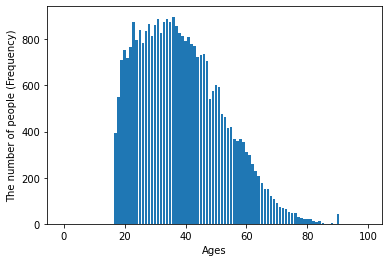

In [3]:
# the domain of ages
age_domain = list(range(0, 100))

# to create the histogram of ages using the age count query, as the synthetic data representation
age_histogram = [age_count_query(age, age + 1) for age in age_domain]

plt.bar(age_domain, age_histogram)
plt.ylabel('The number of people (Frequency)')
plt.xlabel('Ages')

In [4]:
# generate synthetic count query results from the histogram of ages synthetic representation
def synthetic_age_count_query(syn_age_hist_rep, lo, hi):
    return np.sum(syn_age_hist_rep[age] for age in range(lo, hi))

synthetic_age_count_query(age_histogram, 44, 55)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


6577

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


Text(0.5, 0, 'Ages')

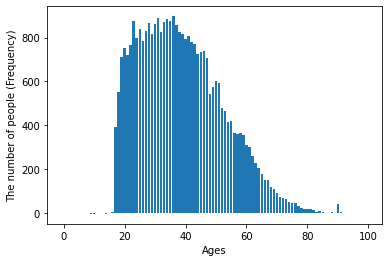

In [5]:
# The Laplace mechanism for differential privacy
def laplace_mechanism(data, sensitivity, epsilon):
    return data + np.random.laplace(loc=0, scale = sensitivity / epsilon)

# Differentially Private Synthetic Histogram Representation Generation
sensitivity = 1.0
epsilon = 1.0
dp_age_histogram = [laplace_mechanism(age_count_query(age, age + 1), sensitivity, epsilon) for age in age_domain]

plt.bar(age_domain, dp_age_histogram)
plt.ylabel('The number of people (Frequency)')
plt.xlabel('Ages')

In [6]:
# generate differentially private count query result using differentially private synthetic histogram
synthetic_age_count_query(dp_age_histogram, 44, 55)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


6574.254079845723

Text(0.5, 0, 'Ages')

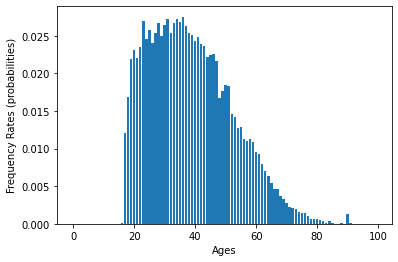

In [7]:
dp_age_histogram_preprocessed = np.clip(dp_age_histogram, 0, None)
dp_age_histogram_normalized = dp_age_histogram_preprocessed / np.sum(dp_age_histogram_preprocessed)

plt.bar(age_domain, dp_age_histogram_normalized)
plt.ylabel('Frequency Rates (probabilities)')
plt.xlabel('Ages')

In [8]:
def syn_tabular_data_gen(cnt):
    return np.random.choice(age_domain, cnt, p = dp_age_histogram_normalized)

syn_tabular_data = pd.DataFrame(syn_tabular_data_gen(10), columns=['Age'])
syn_tabular_data

,Age
0,37
1,39
2,19
3,24
4,68
5,60
6,28
7,42
8,67
9,39


Text(0.5, 0, 'Ages')

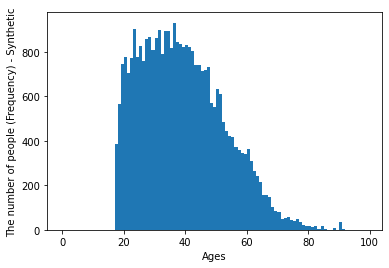

In [9]:
syn_tabular_data = pd.DataFrame(syn_tabular_data_gen(len(adult_age)), columns=['Age'])
plt.hist(syn_tabular_data['Age'], bins=age_domain)
plt.ylabel('The number of people (Frequency) - Synthetic')
plt.xlabel('Ages')

Text(0.5, 0, 'Ages')

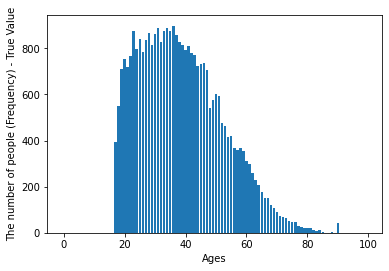

In [10]:
plt.bar(age_domain, age_histogram)
plt.ylabel('The number of people (Frequency) - True Value')
plt.xlabel('Ages')

In [11]:
two_way_marginal_rep = adult.groupby([0, 5]).size().reset_index(name = 'count')
two_way_marginal_rep

,0,5,count
0,17,Married-civ-spouse,2
1,17,Never-married,393
2,18,Divorced,1
3,18,Married-civ-spouse,7
4,18,Married-spouse-absent,1
...,...,...,...
391,90,Divorced,1
392,90,Married-civ-spouse,20
393,90,Never-married,14
394,90,Separated,2


In [12]:
dp_two_way_marginal_rep = laplace_mechanism(two_way_marginal_rep["count"], 1, 1)
dp_two_way_marginal_rep

0        1.261862
1      392.261862
2        0.261862
3        6.261862
4        0.261862
          ...    
391      0.261862
392     19.261862
393     13.261862
394      1.261862
395      5.261862
Name: count, Length: 396, dtype: float64

In [13]:
dp_two_way_marginal_rep_preprocessed = np.clip(dp_two_way_marginal_rep, 0, None)
dp_two_way_marginal_rep_normalized = dp_two_way_marginal_rep_preprocessed / np.sum(dp_two_way_marginal_rep_preprocessed)
dp_two_way_marginal_rep_normalized

0      0.000039
1      0.012156
2      0.000008
3      0.000194
4      0.000008
         ...   
391    0.000008
392    0.000597
393    0.000411
394    0.000039
395    0.000163
Name: count, Length: 396, dtype: float64

In [14]:
age_marital_pairs = [(a,b) for a,b,_ in two_way_marginal_rep.values.tolist()]
list(zip(age_marital_pairs, dp_two_way_marginal_rep_normalized))

[((17, 'Married-civ-spouse'), 3.910483301137522e-05),
 ((17, 'Never-married'), 0.012156110847549155),
 ((18, 'Divorced'), 8.115047807953793e-06),
 ((18, 'Married-civ-spouse'), 0.0001940537590284824),
 ((18, 'Married-spouse-absent'), 8.115047807953793e-06),
 ((18, 'Never-married'), 0.016680619487248687),
 ((18, 'Separated'), 8.115047807953793e-06),
 ((18, 'Widowed'), 8.115047807953793e-06),
 ((19, 'Divorced'), 0.00016306397382506095),
 ((19, 'Married-AF-spouse'), 3.910483301137522e-05),
 ((19, 'Married-civ-spouse'), 0.00044197204065585385),
 ((19, 'Married-spouse-absent'), 7.009461821479667e-05),
 ((19, 'Never-married'), 0.02108116898613453),
 ((19, 'Separated'), 0.00013207418862163953),
 ((20, 'Divorced'), 0.0001940537590284824),
 ((20, 'Married-civ-spouse'), 0.0011547371003345467),
 ((20, 'Married-spouse-absent'), 0.00013207418862163953),
 ((20, 'Never-married'), 0.02151502597898243),
 ((20, 'Separated'), 0.0002250435442319038),
 ((21, 'Divorced'), 0.0001010844034182181),
 ((21, 'Marr

In [15]:
set_of_potential_samples = range(0, len(age_marital_pairs))

n = laplace_mechanism(len(adult), 1.0, 1.0)

generating_synthetic_data_samples = np.random.choice(set_of_potential_samples, int(max(n, 0)), p=dp_two_way_marginal_rep_normalized)
synthetic_data_set = [age_marital_pairs[i] for i in generating_synthetic_data_samples]

synthetic_data = pd.DataFrame(synthetic_data_set, columns=['Age', 'Marital status'])
synthetic_data

,Age,Marital status
0,39,Married-civ-spouse
1,47,Married-civ-spouse
2,26,Never-married
3,38,Married-civ-spouse
4,32,Married-civ-spouse
...,...,...
32555,23,Never-married
32556,34,Never-married
32557,27,Married-civ-spouse
32558,55,Divorced


Text(0.5, 0, 'Ages')

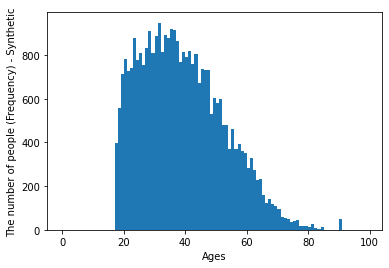

In [16]:
plt.hist(synthetic_data['Age'], bins=age_domain)
plt.ylabel('The number of people (Frequency) - Synthetic')
plt.xlabel('Ages')

Text(0.5, 0, 'Ages')

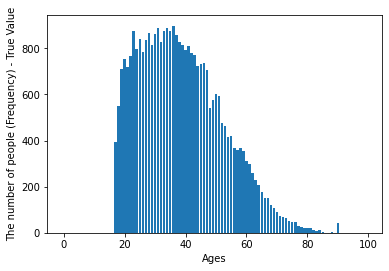

In [17]:
plt.bar(age_domain, age_histogram)
plt.ylabel('The number of people (Frequency) - True Value')
plt.xlabel('Ages')

In [18]:
adult_marital_status = adult[5].dropna()
adult_marital_status.value_counts().sort_index()

Divorced                  4443
Married-AF-spouse           23
Married-civ-spouse       14976
Married-spouse-absent      418
Never-married            10683
Separated                 1025
Widowed                    993
Name: 5, dtype: int64

In [19]:
syn_adult_marital_status = synthetic_data['Marital status'].dropna()
syn_adult_marital_status.value_counts().sort_index()

Divorced                  4313
Married-AF-spouse           12
Married-civ-spouse       15076
Married-spouse-absent      414
Never-married            10739
Separated                 1056
Widowed                    950
Name: Marital status, dtype: int64